SSDの学習済みモデルを使い、サンプル画像の物体検出を行う。 <br />
https://pytorch.org/hub/nvidia_deeplearningexamples_ssd/

In [8]:
import torch

In [ ]:
# COCOデータセットを用い、学習済みのSSDモデルを読み込む
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)

cuda
1.8.2+cu111


In [2]:
ssd_model.to(device)
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [3]:
# 検出対象の画像
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

In [4]:
# 画像をSSDへの入力用へ変換する
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs)

In [5]:
# 物体検出を実行する
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [6]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

In [12]:
best_results_per_input

[[array([[0.65921855, 0.15046567, 0.91532147, 0.7972419 ]], dtype=float32),
  array([1], dtype=int64),
  array([0.9752627], dtype=float32)],
 [array([[0.3339209 , 0.55778325, 0.5873943 , 0.83746815]], dtype=float32),
  array([70], dtype=int64),
  array([0.6216802], dtype=float32)],
 [array([[0.5436169 , 0.10466728, 0.6826829 , 0.24231029],
         [0.50791293, 0.39854738, 0.6820976 , 0.8669088 ]], dtype=float32),
  array([10,  1], dtype=int64),
  array([0.85308903, 0.9989266 ], dtype=float32)]]

In [7]:
classes_to_labels = utils.get_coco_object_dictionary()

In [13]:
classes_to_labels

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

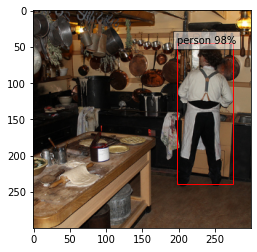

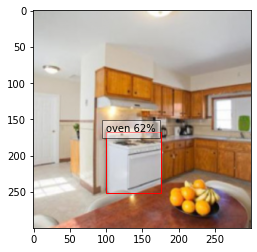

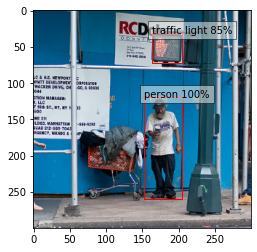

In [9]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# 検出結果の描画
for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

考察
例えば、best_results_per_inputの1番目は `array([1], dtype=int64)` がクラス、 `array([0.9752627], dtype=float32)` が確信度となる。 <br />
classes_to_labels